### Pair Correlation for ICM Organoids

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.spatial.distance import cdist
from Functions import *

C = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

def graphdistance(tri, Dist, cutoff):
    Gr = nx.Graph()
    
    simplices = tri.simplices[(Dist[tri.simplices[:,0],tri.simplices[:,1]] < cutoff) & 
                              (Dist[tri.simplices[:,0],tri.simplices[:,2]] < cutoff) &
                              (Dist[tri.simplices[:,0],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,1],tri.simplices[:,2]] < cutoff) & 
                              (Dist[tri.simplices[:,1],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,2],tri.simplices[:,3]] < cutoff)]
    
    
    for path in simplices:
        nx.add_path(Gr, path)
        
    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    dist = np.empty([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            dist[i,j] = dist_dict[i][j]
            
    
    return dist
    

def paircorrelation(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    x[(Population == Type)] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P


def correlation_correction(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    y = np.zeros(len(Population))
    x[(Population == Type)] = 1
    y[(Population == 'N+G+') | (Population == 'N-G-')] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    cor_ind = np.where(y==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        equals = GraphDist[ind].T[ind].T
        mixed = GraphDist[cor_ind].T[ind].T
        none =  GraphDist[cor_ind].T[cor_ind].T
        
        rho_equals = sum(x)*(sum(x)-1)/len(x)/(len(x)-1)
        rho_mixed = sum(x)*sum(y)/len(x)/(len(x)-1)
        rho_none = sum(y)*(sum(y)-1)/len(x)/(len(x)-1)
        
        rho_total = (sum(x) + sum(y)/2)*(sum(x)-1 + sum(y)/2)/len(x)/(len(x)-1)

        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = (len(equals[equals==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + len(mixed[mixed==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + 0.25*len(none[none==i])/len(GraphDist[GraphDist==i])/rho_total)

    return P


N = []
G = []
N_cor = []
G_cor = []
DN = []
DP = []
nofCells = []
Stage = []
N_mean = 0
G_mean = 0
DN_mean = 0
DP_mean = 0
number = 0
for K in range(max(C['OrganoidID'])):
    Organoids = max(C['OrganoidID'])
    ID = K+1
    Cindex = []
    Cells = []

    for i in range(len(C)):
        if C['OrganoidID'][i] == ID:
            Cindex.append(i)

    x = np.array(C.loc[Cindex,'CentroidX'])
    y = np.array(C.loc[Cindex,'CentroidY'])
    z = np.array(C.loc[Cindex,'CentroidZ'])
    Nanog = np.array(C.loc[Cindex,'Nanog-Avg'])
    Gata6 = np.array(C.loc[Cindex,'Gata6-Avg'])
    Population = np.array(C.loc[Cindex,'Population'])
    stage = np.array(C.loc[Cindex,'stage'])
    
    nofN = len(Population[Population == 'N+G-'])
    nofG = len(Population[Population == 'N-G+'])
    nofDP = len(Population[Population == 'N+G+'])
    nofDN = len(Population[Population == 'N-G-'])
    
    #if nofDN/len(x) + nofDP/len(x) > 0.25 or stage[0]=='24h' or nofN/nofG > 2 or nofG/nofN > 2:
    #if stage[0]=='24h':
    if (nofDN/len(x) + nofDP/len(x) > 0.30 or nofDN/len(x) + nofDP/len(x) < 0.20 or stage[0]=='24h' or
        nofN/len(x) < 0.248 or nofN/len(x) > 0.448 or
        nofG/len(x) < 0.307 or nofG/len(x) > 0.507):
        continue

    #N_mean += nofN/len(x)
    #G_mean += nofG/len(x)
    #DN_mean += nofDN/len(x)
    #DP_mean += nofDP/len(x)
    #number += 1
        
    print('Organoid', ID, 'consists of', len(Cindex), 'cells')

    pos = np.empty([len(x), 3])
    pos[:,0] = x
    pos[:,1] = y
    pos[:,2] = z

    Dist = cdist(pos, pos)
    tri = Delaunay(pos)
    GraphDist = graphdistance(tri, Dist, 91)
    
    #Population[Nanog > Gata6] = 'N+G-'
    #Population[Nanog <= Gata6] = 'N-G+'
    N.append(paircorrelation(Population, 'N+G-', GraphDist))
    G.append(paircorrelation(Population, 'N-G+', GraphDist))
    N_cor.append(correlation_correction(Population, 'N+G-', GraphDist))
    G_cor.append(correlation_correction(Population, 'N-G+', GraphDist))
    DN.append(paircorrelation(Population, 'N-G-', GraphDist))
    DP.append(paircorrelation(Population, 'N+G+',GraphDist))
    Stage.append(stage[0])
    nofCells.append(len(x))
    
print('Finished!')

Organoid 14 consists of 1531 cells
Organoid 20 consists of 1410 cells
Organoid 49 consists of 977 cells
Organoid 66 consists of 952 cells
Finished!


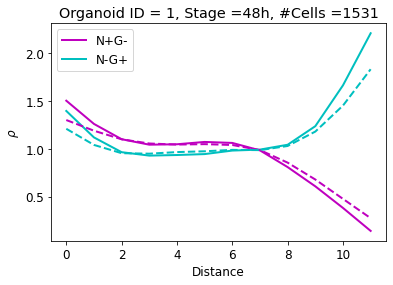

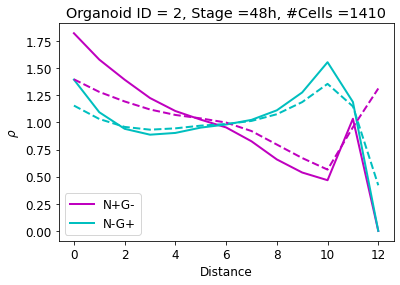

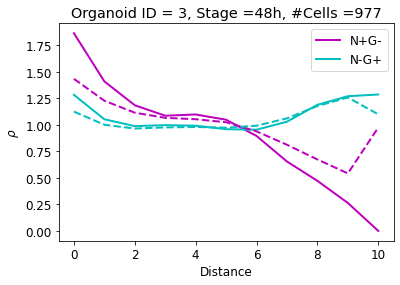

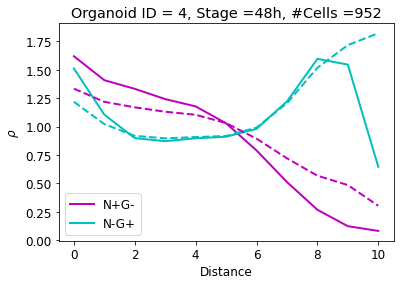

In [5]:
for i in range(len(N)):
    plt.figure()
    plt.rc('font', size=12)
    plt.plot(N[i], 'm', lw=2, label = 'N+G-')
    plt.plot(G[i], 'c', lw=2, label = 'N-G+')
    plt.plot(N_cor[i], 'm--', lw=2)
    plt.plot(G_cor[i], 'c--', lw=2)
    #plt.plot(DP[i], 'k--', alpha = 0.5, lw=2, label = 'N+G+')
    #plt.plot(DN[i], 'k', ls='dotted', alpha = 0.5, lw=2, label = 'N-G-')
    plt.title('Organoid ID = '+str(i+1)+ ', Stage ='+str(Stage[i])+', #Cells ='+str(nofCells[i]))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho$')
    plt.legend()
    #plt.savefig('Results/Pair Correlations (without DN DP)/ID='+str(i+1)+'.png')

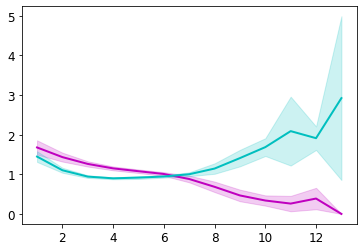

In [16]:
maxdist = 0
for i in range(len(N)):
    if maxdist < len(N[i]):
        maxdist = len(N[i])

amount = np.zeros(maxdist)
N_mean = np.zeros(maxdist)
G_mean = np.zeros(maxdist)
N_std = np.zeros(maxdist)
G_std = np.zeros(maxdist)
DN_mean = np.zeros(maxdist)
DP_mean = np.zeros(maxdist)
DN_std = np.zeros(maxdist)
DP_std = np.zeros(maxdist)
x = list(range(1,maxdist+1))
for i in range(len(N)):
    for j in range(len(N[i])):
        N_mean[j] += N[i][j]
        G_mean[j] += G[i][j]
        DN_mean[j] += DN[i][j]
        DP_mean[j] += DP[i][j]
        amount[j] += 1
        
N_mean = N_mean/amount
G_mean = G_mean/amount


for i in range(len(N)):
    for j in range(len(N[i])):
        N_std[j] += (N[i][j]-N_mean[j])**2
        G_std[j] += (G[i][j]-G_mean[j])**2
        DN_std[j] += (DN[i][j]-DN_mean[j])**2
        DP_std[j] += (DP[i][j]-DP_mean[j])**2
        amount[j] += 1

N_std = (N_std/amount)**(1/2)
G_std = (G_std/amount)**(1/2)
DN_std = (DN_std/amount)**(1/2)
DP_std = (DP_std/amount)**(1/2)
        
plt.plot(x, N_mean, 'm', lw = 2)
plt.plot(x, G_mean, 'c', lw = 2)
#plt.plot(x, DN_mean, 'k', lw = 2)
#plt.plot(x, DP_mean, 'b', lw = 2)
plt.fill_between(x, N_mean - N_std, N_mean + N_std, color='m', alpha = 0.2)
plt.fill_between(x, G_mean - G_std, G_mean + G_std, color='c', alpha = 0.2)
#plt.fill_between(x, DN_mean - DN_std, DN_mean + DN_std, color='k', alpha = 0.2)
#plt.fill_between(x, DP_mean - DP_std, DP_mean + DP_std, color='b', alpha = 0.2)

<br>
<br>
<br>

### Pair correlation for non-local model data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import loadData, fate
import networkx as nx

N = np.empty([9,177])
G = np.empty([9,177])

Pos, Radius, N[0,:], G[0,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=1_10/Data.csv')
Pos, Radius, N[1,:], G[1,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=2_10/Data.csv')
Pos, Radius, N[2,:], G[2,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=3_10/Data.csv')
Pos, Radius, N[3,:], G[3,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=4_10/Data.csv')
Pos, Radius, N[4,:], G[4,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=5_10/Data.csv')
Pos, Radius, N[5,:], G[5,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=6_10/Data.csv')
Pos, Radius, N[6,:], G[6,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=7_10/Data.csv')
Pos, Radius, N[7,:], G[7,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=8_10/Data.csv')
Pos, Radius, N[8,:], G[8,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=9_10/Data.csv')

FVmesh = initializeFVmesh(Pos, Radius=Radius)
Gr = nx.Graph()
for path in FVmesh.Tri.simplices:

    path1 = [path[0], path[1]]
    path2 = [path[1], path[2]]
    path3 = [path[2], path[0]]

    if FVmesh.Dist[path1[0],path1[1]] < 2.2:
        nx.add_path(Gr, path1)
    if FVmesh.Dist[path2[0],path2[1]] < 2.2:    
        nx.add_path(Gr, path2)
    if FVmesh.Dist[path3[0],path3[1]] < 2.2:
        nx.add_path(Gr, path3)
    
dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
GraphDist = np.empty([FVmesh.nofCells, FVmesh.nofCells])
for i in range(FVmesh.nofCells):
    for j in range(FVmesh.nofCells):
        GraphDist[i,j] = dist_dict[i][j]

colors = np.linspace(0,1,9)       
cmap = matplotlib.cm.get_cmap('jet')
plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(N[i,:], G[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')

test = np.linspace(0,1,len(PN)-2)
plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.png')

plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(G[i,:], N[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.png')

<br>
<br>
<br>

### Pair correlation / cell ratio for local model data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import networkx as nx
import pandas as pd
import os

def paircorrelation(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P


Prm = setParameters()
#Organoid = initializeOrganoid(Prm)
Pos = np.array(pd.read_csv('testOrganoid.csv'))
Radius = np.ones(len(Pos))*1.1
FVmesh = initializeFVmesh(Pos, Radius=Radius)


x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
xInit = np.array([gauss(x0[0],x0[0]*0.01) if i < FVmesh.nofCells else 
                  gauss(x0[1],x0[1]*0.01) for i in range(2*FVmesh.nofCells)])

eps_G = np.linspace(6,7.86,20)
Ratio = np.empty(eps_G.shape)
PN = np.empty([len(eps_G), int(np.max(FVmesh.GraphDist))])
PG = np.empty([len(eps_G), int(np.max(FVmesh.GraphDist))])

for i in range(len(eps_G)):
    Prm.eps_G = -eps_G[i]
    Prm.T = 2400
    Prm.nofSteps = 3000
    t = np.linspace(0,Prm.T,Prm.nofSteps)
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = solve_ivp(rhs, [0,Prm.T], xInit, t_eval = t, method = 'Radau')

    N = sol.y[:FVmesh.nofCells,-1]
    G = sol.y[FVmesh.nofCells:,-1]

    F = fate(N, G)
    PN[i,:] = paircorrelation(N, G, FVmesh.GraphDist)
    PG[i,:] = paircorrelation(G, N, FVmesh.GraphDist)

    Ratio[i] = np.sum(F)/FVmesh.nofCells



plt.rc('font', size=14)
plt.plot(eps_G, Ratio, 'c', alpha=0.5, lw=2, label = 'GATA6')
plt.plot(eps_G, Ratio, 'm', alpha=0.5, lw=2, label = 'NANOG')
plt.fill_between(eps_G, Ratio, 1, color='c', alpha = 0.2)
plt.fill_between(eps_G, 0, Ratio, color='m', alpha = 0.2)
plt.legend()
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportion')

In [ ]:
plt.figure()
plt.rc('font', size=14)
plt.plot(eps_G, Ratio, 'c', alpha=0.5, lw=2, label = 'GATA6')
plt.plot(eps_G, Ratio, 'm', alpha=0.5, lw=2, label = 'NANOG')
plt.fill_between(eps_G, Ratio, 1, color='c', alpha = 0.2)
plt.fill_between(eps_G, 0, Ratio, color='m', alpha = 0.2)
plt.legend()
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportion')
#plt.savefig('Results/Publications/Pattern Formation/Proportions.pdf')
#plt.savefig('Results/Publications/Pattern Formation/Proportions.png')

PN_mean = np.mean(PN, axis=0)
PN_std = np.std(PN, axis=0)
PG_mean = np.mean(PG, axis=0)
PG_std = np.std(PG, axis=0)


plt.figure()
plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PN_mean, 'm')
plt.fill_between(distances, PN_mean-PN_std, PN_mean+PN_std, color='m', alpha = 0.2)
plt.ylim([0,2])

plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PG_mean, 'c')
plt.fill_between(distances, PG_mean-PG_std, PG_mean+PG_std, color='c', alpha = 0.2)

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(PN)-2)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PN)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PN[i+1,:], color = rgba, lw=2)
plt.xlabel('Distance')
plt.ylabel('$\\rho_n$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.png')

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PG)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PG[i+1,:], color = rgba, lw=2)
plt.xlabel('Distance')
plt.ylabel('$\\rho_g$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.png')

In [ ]:
a = np.array([[6,7.86]])
plt.figure(figsize=(10, 4))
img = plt.imshow(a, cmap="jet")
plt.gca().set_visible(False)
plt.colorbar(orientation="vertical", label='$-\Delta\epsilon_g$', ticks=[6,6.93,7.86])
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.pdf")
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.png")

# ML Training Data

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

DATA = pd.DataFrame()
for i in range(100):
    Prm = setParameters()
    #Prm.eps_G = -9.1
    #Prm.range = 0.9
    Prm.nofCells_end = 150 + np.random.normal(0,10)
    Organoid = initializeOrganoid(Prm, Transcription=False)
    Pos = Organoid.Pos
    #Pos = np.array(pd.read_csv('testOrganoid_small.csv'))
    Radius = np.ones(len(Pos))*1.1
    FVmesh = initializeFVmesh(Pos, Radius=Radius)

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = solve_ivp(rhs, [0,Prm.T], xInit, t_eval = t, method = 'Radau')

    N = sol.y[:FVmesh.nofCells,-1]
    G = sol.y[FVmesh.nofCells:,-1]
    F = fate(N,G)
   
    print('ID =', i, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

    df = pd.DataFrame()
    df['ID'] = i*np.ones(len(F), dtype=int)
    df['x'] = Pos[:,0]
    df['y'] = Pos[:,1]
    df['fate'] = F
    DATA = DATA.append(df)
    
DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/Organoids q=0.1.csv', index=False)

Expected cell division time = 5.783268644039033
Expected number of Cells = 91.03277841977166
ID = 0 Total = 149 NANOG = 75 GATA6 = 74
Expected cell division time = 5.777279659168567
Expected number of Cells = 91.3531944820169
ID = 1 Total = 131 NANOG = 66 GATA6 = 65
Expected cell division time = 5.974186808621209
Expected number of Cells = 81.70541984320508
ID = 2 Total = 123 NANOG = 64 GATA6 = 59
Expected cell division time = 6.02048226914208
Expected number of Cells = 79.67854788669399
ID = 3 Total = 134 NANOG = 68 GATA6 = 66
Expected cell division time = 5.882427942740436
Expected number of Cells = 85.98276745956713
ID = 4 Total = 140 NANOG = 71 GATA6 = 69
Expected cell division time = 5.829145480731844
Expected number of Cells = 88.63781690056246
ID = 5 Total = 164 NANOG = 84 GATA6 = 80
Expected cell division time = 5.796740084410105
Expected number of Cells = 90.31868686562656
ID = 6 Total = 123 NANOG = 61 GATA6 = 62
Expected cell division time = 5.989648213290512
Expected number 

Expected cell division time = 6.1747774390857035
Expected number of Cells = 73.49029968868408
ID = 61 Total = 116 NANOG = 57 GATA6 = 59
Expected cell division time = 6.215603494026634
Expected number of Cells = 71.98594122267903
ID = 62 Total = 132 NANOG = 65 GATA6 = 67
Expected cell division time = 5.953201644318357
Expected number of Cells = 82.65234225561306
ID = 63 Total = 122 NANOG = 60 GATA6 = 62
Expected cell division time = 5.730660613978122
Expected number of Cells = 93.91124251644577
ID = 64 Total = 162 NANOG = 83 GATA6 = 79
Expected cell division time = 5.741911544817592
Expected number of Cells = 93.28334252368595
ID = 65 Total = 130 NANOG = 67 GATA6 = 63
Expected cell division time = 5.866998971139783
Expected number of Cells = 86.73807804681832
ID = 66 Total = 142 NANOG = 72 GATA6 = 70
Expected cell division time = 5.850889874755969
Expected number of Cells = 87.53833160808227
ID = 67 Total = 140 NANOG = 71 GATA6 = 69
Expected cell division time = 6.091006007519324
Expect